# Using Atlite to retrieve historical data and conversion to power generation potentials for South Africa's Renewable Energy Development Zones

This jupyter notebook documents how to retrieve historical weather data from Atlite and through a cutout and consequently gnerate profiles for wind and solar PV. The notebook is based on generation potentials for South Africa's Renewable Energy Development Zones (REDZs). Links are provided to download shape files for the REDZs provided at the Department of Forestry, Fisheries and the Environment of the Republic of South Africa. 

- Atlite is documented in https://joss.theoj.org/papers/10.21105/joss.03294
- Atlite tutorials are documented in https://github.com/PyPSA/atlite/tree/master/examples 
- Renewable Energy Development Zones (REDZs) shape files are located at https://egis.environment.gov.za/data_egis/data_download/current. A user profile is to be created before downloading the shape files.

Inputs:
- Shape file
    - Phase 1 and Phase 2 REDZs shape files from https://egis.environment.gov.za/data_egis/data_download/ 

Outputs:
- A cutout with spatio-temporal bounds given by extent of the REDZs at hourly intervals for the year 2013
- Cutout contains 


The dependencies required to read the shape files into geo pandas data frames are imported together with the atlite module.

In [16]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import atlite

from shapely.ops import unary_union
import numpy as np
import rasterio
import shapely
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
projection = ccrs.Orthographic(20, 0)

## Reading REDZs shape file

Download and unzip the files Phase1_REDZs.zip and Phase2_REDZs.zip from https://egis.environment.gov.za/data_egis/data_download/ .

The shape files have extension .shp and can be read into the jupyter notebook using geo pandas

In [17]:
REDZ_shapefile_1 = gpd.read_file('../data/supply_regions/supply_regions_27-supply.shp')
REDZ_shapefile_2 = gpd.read_file('../data/supply_regions/supply_regions_27-supply.shp')
resarea = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')
REDZ_shapefile_1 = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')

The first shape file REDZ_shapefile_1 gives the 8 REDZs identified in Phase 1 while the second shape file REDZ_shapefile_1 gives 3 additional REDZs identified in Phase 2. The Phase 1 shape file is projected to a coordinate reference system 'epsg:32635' and then to 'epsg:4326' using the to_crs().

In [18]:
REDZ_shapefile_1 = REDZ_shapefile_1.to_crs('epsg:32635')
resarea = resarea.to_crs('epsg:32635')

To do a a single cutout using atlite which covers all the REDZs we create a geo data frame using geo pandas of the concatenated shape files. The shape files have different information so values with NAN are removed 

In [19]:
#unified_redz_shape = pd.concat([REDZ_shapefile_1.to_crs('epsg:4326'),REDZ_shapefile_2])
REDZ = REDZ_shapefile_1.to_crs('epsg:4326')
resarea = resarea.to_crs('epsg:4326')
#REDZ = gpd.GeoDataFrame(unified_redz_shape)
#REDZ = REDZ["geometry"][REDZ["geometry"].is_valid]

REDZ = gpd.GeoDataFrame(REDZ).set_index(REDZ.Name)
REDZ = REDZ.rename(columns={0: "geometry"}).set_geometry("geometry")

unified_shape_file = unary_union(REDZ["geometry"])
unified_shape = gpd.GeoDataFrame(geometry=[unified_shape_file],crs=4326)

## Create a cutout with spatio-temporal bounds given by extent of the REDZs

Determine the extent of the cutout by determining the bounds of the unified_shape created above. Use the geographical bounds as input to the cutout

In [20]:
bounds = unified_shape.unary_union.bounds
cutout = atlite.Cutout(path="../cutouts/RSA-2012-era5.nc", # name of file to save cutout
                       module="era5", # database
                       bounds=bounds, # geographical bounds including all 27 regions
                       time=slice('2012-01-01', '2013-01-01')) # January 2011

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/atlite/cutout.py:187: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


To prepare the cutout follow the exaple given in the atlite documentation especially setting up of the ADS key. Prepare the cutup. This is the time consuming step as all the data from the is retrieved here. 

In [21]:
cutout.prepare()
cells = cutout.grid

The cutout region and the REDZs are plotted following the examples from atlite

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_239032/2128976501.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


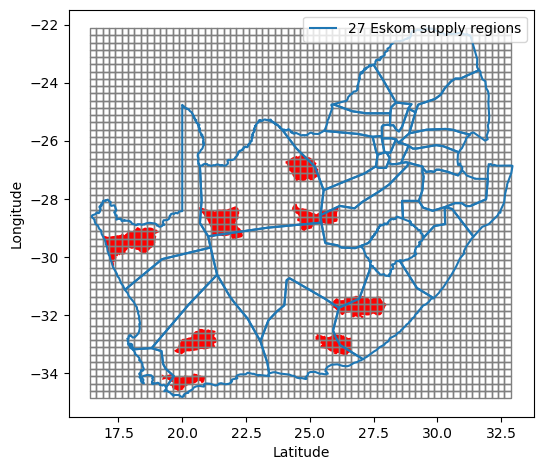

In [22]:
fig, ax = plt.subplots(figsize=(6,6));
unified_shape.plot(ax=ax, label='REDZs',color='Red');
cutout.grid.plot(ax=ax, edgecolor='grey', color='None', label='Cutout geographical bounds');

supply_regions_shapefile = shpreader.Reader('../data/supply_regions/supply_regions_27-supply.shp')

supply_regions = gpd.GeoSeries({r.attributes['name']: r.geometry
                      for r in supply_regions_shapefile.records()},
                      crs={'init': 'epsg:4326'}
                     )
supply_regions.boundary.plot(ax=ax, label='27 Eskom supply regions')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend()

In [23]:
# Create exclusion container to exclude SAPAD and SACAD from the shape file. Available area is also
# shown
cap_per_sqkm = 1.7 #

excluder = atlite.ExclusionContainer()
excluder.add_geometry('../data/bundle/SACAD_OR_2017_Q2/SACAD_OR_2017_Q2.shp')
excluder.add_geometry('../data/bundle/SAPAD_OR_2017_Q2/SAPAD_OR_2017_Q2.shp')

availability_matrix = cutout.availabilitymatrix(REDZ.to_crs(excluder.crs),excluder)

area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape),
                        [cutout.coords['y'], cutout.coords['x']])
potential = availability_matrix * area * cap_per_sqkm


Compute availability matrix: 100%|██████████| 8/8 [00:01<00:00,  4.74 gridcells/s]


# Wind power analysis

In [24]:
capacity_factor = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

In [25]:
cell_ws_mean = 0*capacity_factor.to_pandas().copy()
cell_ws_max = 0*capacity_factor.to_pandas().copy()
era5_wnd100m=cutout.data.wnd100m.to_dataframe()
src=rasterio.open('../data/bundle/ZAF_wind-speed_100m.tif')
for c in cells.index:
    mm=cells.geometry.bounds.loc[c,:]
    window = rasterio.windows.from_bounds(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'], src.transform)

    box = shapely.geometry.box(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'])
    transform = rasterio.windows.transform(window, src.transform)

    src_data = src.read(1, window=window)
    xpos = cells.loc[c,'x']
    ypos = cells.loc[c,'y']
    cell_ws_max.loc[ypos,xpos] = src_data.max()
    cell_ws_mean.loc[ypos,xpos] = src_data.mean()
    era5_wnd100m.loc[(slice(None),ypos,xpos),'wnd100m']*=(src_data.mean()/era5_wnd100m.loc[(slice(None),ypos,xpos),'wnd100m'].mean())
  
    print(c)

In [ ]:
ds = era5_wnd100m.to_xarray().chunk(cutout.chunks)
cutout.data.wnd100m.data=ds.wnd100m.data

In [ ]:
cf = capacity_factor.to_pandas()
cf[cf>0.3] = 1
cf[cf<=0.3] = 0
for redz_loc in range(0,len(availability_matrix.coords['name'])):
    availability_matrix.values[redz_loc,:,:] = np.multiply(availability_matrix.values[redz_loc,:,:],cf)

In [ ]:

capacity_factor = cutout.pv(panel='CSi', orientation='latitude_optimal',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm


In [ ]:
# Prepare the cut-out. Commented out as cutout is already downloaded.
#cutout.prepare()

profile_pv, capacities_pv = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)



In [ ]:
capacity_factor = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

In [ ]:
cf = capacity_factor.to_pandas()
cf[cf>0.3] = 1
cf[cf<=0.3] = 0
for redz_loc in range(0,len(availability_matrix.coords['name'])):
    availability_matrix.values[redz_loc,:,:] = np.multiply(availability_matrix.values[redz_loc,:,:],cf)

In [ ]:
layout = capacity_factor * area * cap_per_sqkm

In [ ]:
profile_pv, capacities_pv = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

In [ ]:
profile_wind2, capacities_wind2 = cutout.wind('Vestas_V112_3MW',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

In [ ]:
profile_wind2.to_pandas().mean()

Name
Stormberg - REDZ4    0.401990
Komsberg - REDZ2     0.360059
Cookhouse - REDZ3    0.324648
Springbok - REDZ8    0.000000
Kimberley - REDZ5    0.228829
Overberg - REDZ1     0.337440
Vryburg - REDZ6      0.254896
Upington - REDZ7     0.252531
dtype: float64

In [ ]:
profile_wind.to_pandas().mean()

Name
Stormberg - REDZ4    0.180253
Komsberg - REDZ2     0.234580
Cookhouse - REDZ3    0.177961
Springbok - REDZ8    0.247609
Kimberley - REDZ5    0.186784
Overberg - REDZ1     0.208960
Vryburg - REDZ6      0.188957
Upington - REDZ7     0.249622
dtype: float64

## Some plotting with Atlite

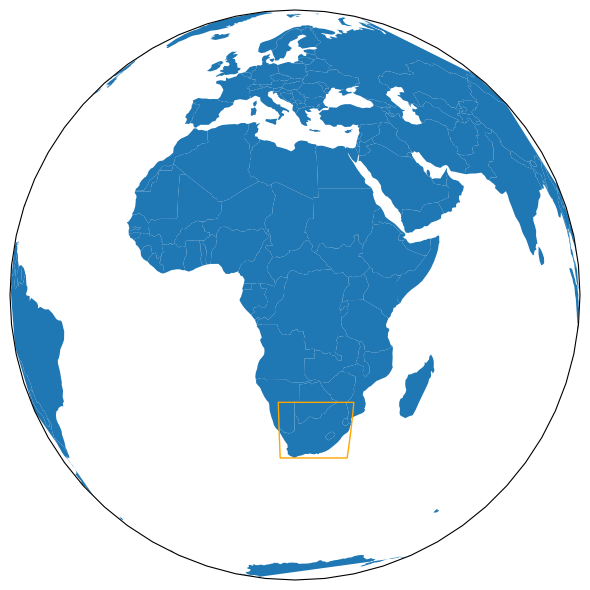

In [ ]:
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate

projection = ccrs.Orthographic(20, 0)
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_bound = gpd.GeoSeries(cells.unary_union)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
fig.tight_layout()

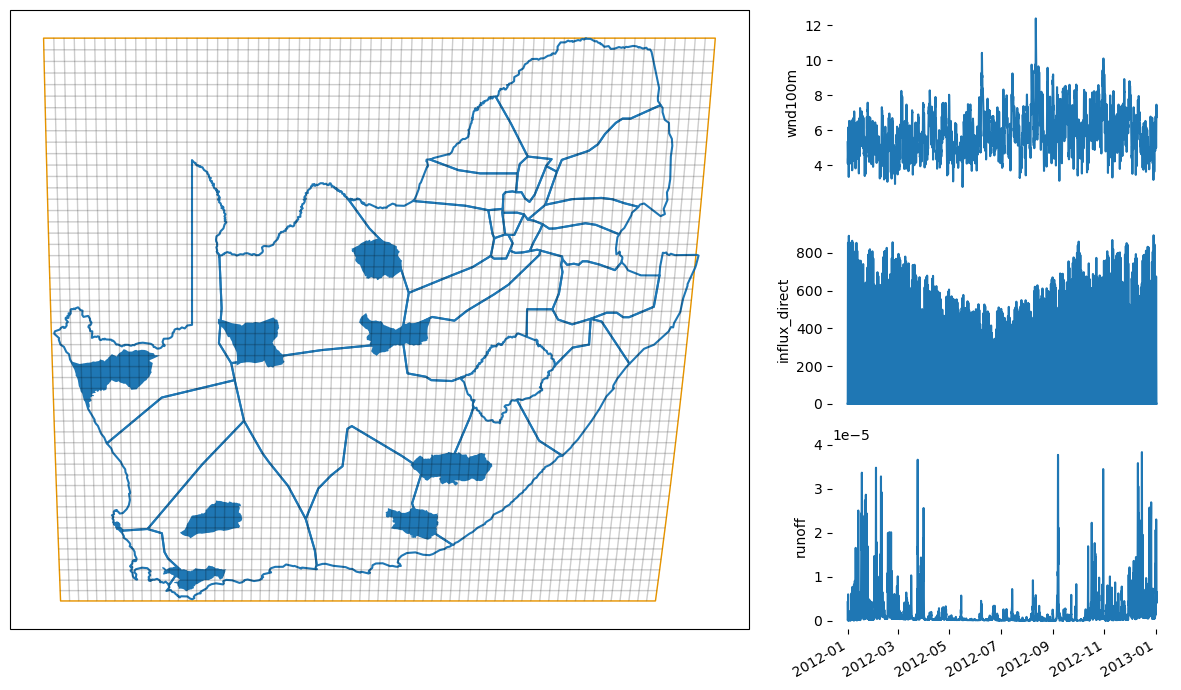

In [ ]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
#ax.outline_patch.set_edgecolor('white')
REDZ.plot(ax=ax, zorder=1, transform=plate())
supply_regions.boundary.plot(ax=ax, zorder=1, transform=plate())
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()

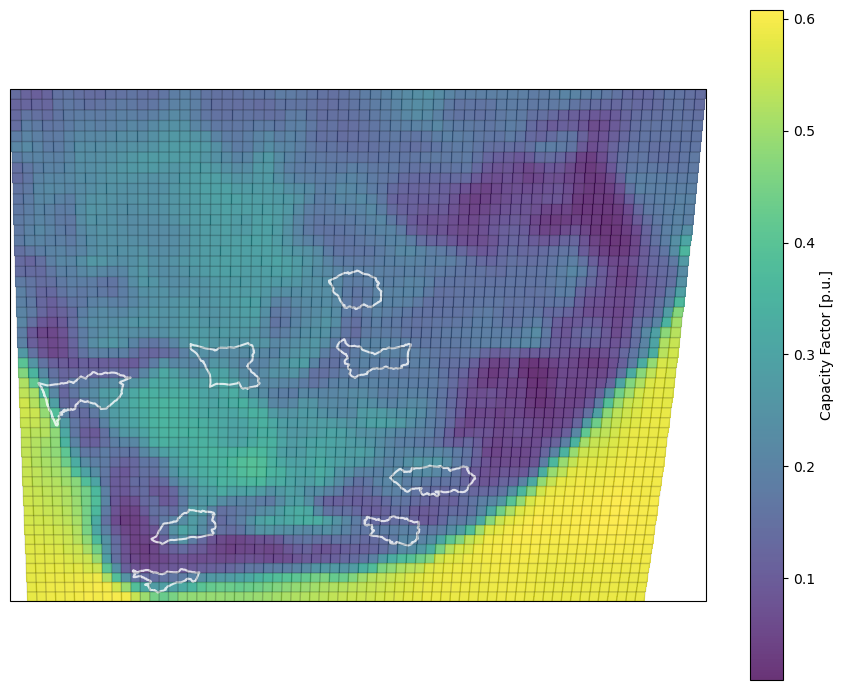

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
capacity_factor.name = 'Capacity Factor'
capacity_factor.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

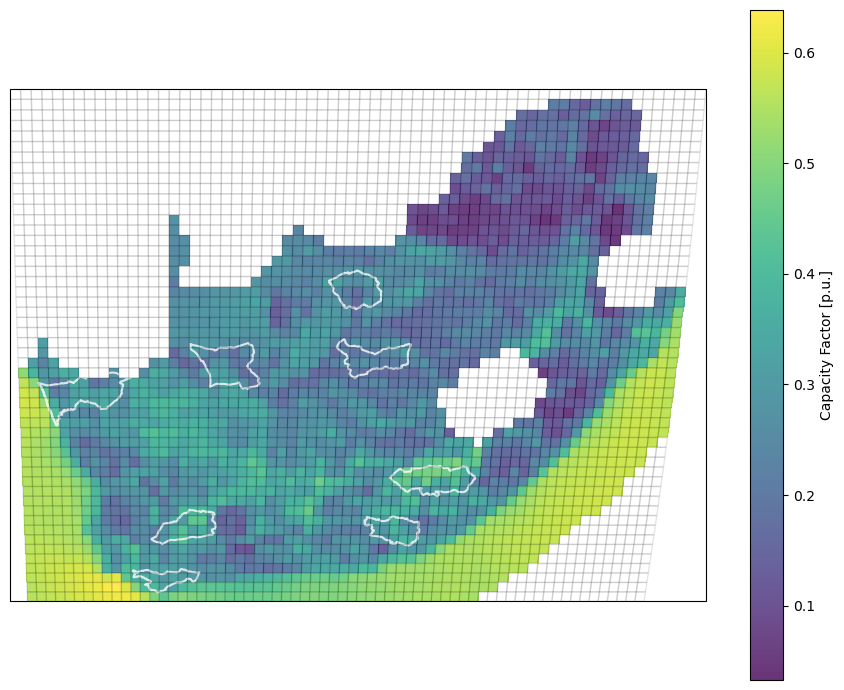

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
capacity_factor2.name = 'Capacity Factor'
capacity_factor2.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [ ]:
cell_ws_mean = 0*capacity_factor.to_pandas().copy()
cell_ws_max = 0*capacity_factor.to_pandas().copy()
max_xr = 0*capacity_factor.copy()
min_xr = 0*capacity_factor.copy()
cf_ratio = 0*capacity_factor.copy()

In [ ]:
wind_speed2=cutout.data.wnd100m.to_dataframe()


In [ ]:
src=rasterio.open('../data/bundle/ZAF_wind-speed_100m.tif')
for c in cells.index:
    mm=cells.geometry.bounds.loc[c,:]
    window = rasterio.windows.from_bounds(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'], src.transform)

    box = shapely.geometry.box(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'])
    transform = rasterio.windows.transform(window, src.transform)

    src_data = src.read(1, window=window)
    xpos = cells.loc[c,'x']
    ypos = cells.loc[c,'y']
    cell_ws_max.loc[lon,lat] = src_data.max()
    cell_ws_mean.loc[lon,lat] = src_data.mean()
    wind_speed.loc[(slice(None),ypos,xpos),'wnd100m']*=(src_data.mean()/wind_speed.loc[(slice(None),ypos,xpos),'wnd100m'].mean())
  
    print(c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
ds=wind_speed.to_xarray()

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 8808, y: 51, x: 66)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2013-01-01T23:00:00
  * y        (y) float64 -34.75 -34.5 -34.25 -34.0 ... -23.0 -22.75 -22.5 -22.25
  * x        (x) float64 16.5 16.75 17.0 17.25 17.5 ... 32.0 32.25 32.5 32.75
Data variables:
    lon      (time, y, x) float64 16.5 16.75 17.0 17.25 ... 32.25 32.5 32.75
    lat      (time, y, x) float64 -34.75 -34.75 -34.75 ... -22.25 -22.25 -22.25
    wnd100m  (time, y, x) float32 7.997 7.819 7.596 7.458 ... 5.965 5.12 4.58

In [ ]:
ds.chunk(cutout.chunks).wnd100m.data

array([[[ 7.735416 ,  7.5973554,  7.397305 , ...,        nan,
                nan,        nan],
        [ 7.333413 ,  7.219581 ,  7.06874  , ...,        nan,
                nan,        nan],
        [ 7.0501194,  6.971734 ,  6.8710704, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 8.168949 ,  7.9869432,  7.7085433, ...,        nan,
                nan,        nan],
        [ 7.567916 ,  7.401341 ,  7.1776137, ...,        nan,
                nan,        nan],
        [ 7.0567193,  6.9284253,  6.7813573, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [   

In [ ]:
ds.chunk(cutout.chunks).wnd100m

<xarray.DataArray 'wnd100m' (time: 8808, y: 51, x: 66)>
dask.array<xarray-wnd100m, shape=(8808, 51, 66), dtype=float32, chunksize=(100, 51, 66), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2013-01-01T23:00:00
  * y        (y) float64 -34.75 -34.5 -34.25 -34.0 ... -23.0 -22.75 -22.5 -22.25
  * x        (x) float64 16.5 16.75 17.0 17.25 17.5 ... 32.0 32.25 32.5 32.75

In [ ]:
cutout.data.wnd100m

<xarray.DataArray 'wnd100m' (time: 8808, y: 51, x: 66)>
dask.array<open_dataset-f850f3f6ab42defa3ca2635c265278a4wnd100m, shape=(8808, 51, 66), dtype=float32, chunksize=(100, 51, 66), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 16.5 16.75 17.0 17.25 17.5 ... 32.0 32.25 32.5 32.75
  * y        (y) float64 -34.75 -34.5 -34.25 -34.0 ... -23.0 -22.75 -22.5 -22.25
  * time     (time) datetime64[ns] 2012-01-01 ... 2013-01-01T23:00:00
    lon      (x) float64 dask.array<chunksize=(66,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(51,), meta=np.ndarray>
Attributes:
    units:      m s**-1
    long_name:  100 metre wind speed
    module:     era5
    feature:    wind

In [ ]:
cutout.data.wnd100m.data=ds.chunk(cutout.chunks).wnd100m.data

In [ ]:
cutout.data.wnd100m.to_dataframe()

lon    lat   wnd100m
time                y      x                            
2012-01-01 00:00:00 -34.75 16.50  16.50 -34.75  7.735416
                           16.75  16.75 -34.75  7.597355
                           17.00  17.00 -34.75  7.397305
                           17.25  17.25 -34.75  7.328130
                           17.50  17.50 -34.75  7.184596
...                                 ...    ...       ...
2013-01-01 23:00:00 -22.25 31.75  31.75 -22.25       NaN
                           32.00  32.00 -22.25       NaN
                           32.25  32.25 -22.25       NaN
                           32.50  32.50 -22.25       NaN
                           32.75  32.75 -22.25       NaN

[29647728 rows x 3 columns]

In [ ]:
capacity_factor2 = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)

In [ ]:
capacity_factor2.plot()

<AxesSubplot: xlabel='time,y,x'>

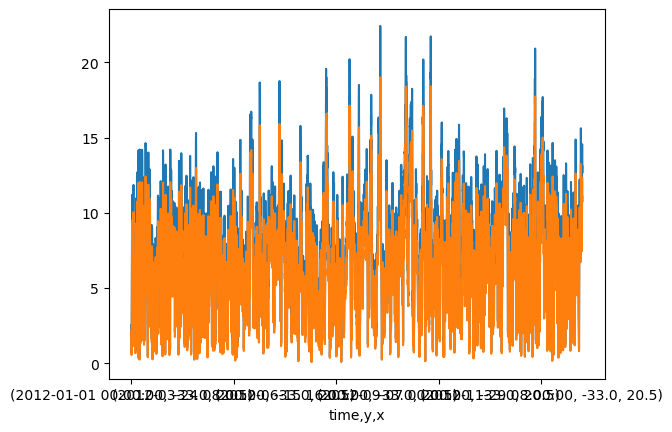

In [ ]:
wind_speed.fillna(0).loc[(slice(None),-33,20.5),'wnd100m'].plot()
wind_speed2.loc[(slice(None),-33,20.5),'wnd100m'].plot()

In [ ]:
cutout.wind

In [ ]:
wind_speed.loc[(cells.loc[c,'x'],cells.loc[c,'y']),'wnd100m']*1.5

/tmp/ipykernel_231017/147711271.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_speed.loc[(cells.loc[c,'x'],cells.loc[c,'y']),'wnd100m']*1.5


time
2012-01-01 00:00:00    11.995993
2012-01-01 01:00:00    12.668310
2012-01-01 02:00:00    13.285473
2012-01-01 03:00:00    12.994907
2012-01-01 04:00:00    12.471853
                         ...    
2013-01-01 19:00:00    20.816444
2013-01-01 20:00:00    20.189405
2013-01-01 21:00:00    19.078287
2013-01-01 22:00:00    17.872875
2013-01-01 23:00:00    16.557432
Name: wnd100m, Length: 8808, dtype: float32

In [ ]:
cf_ratio.data=np.divide(capacity_factor.data,cell_mean.fillna(-1).values)

(51, 66)

In [ ]:
np.shape(capacity_factor.data)

(51, 66)

In [ ]:
from matplotlib.cm import ScalarMappable

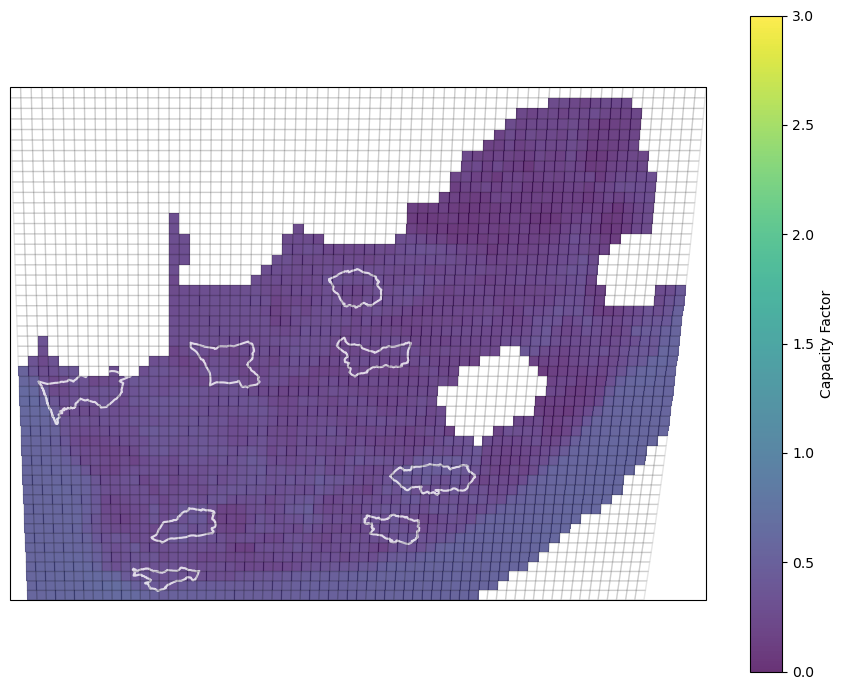

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
mean_xr.name = 'Capacity Factor'
mean_xr.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();





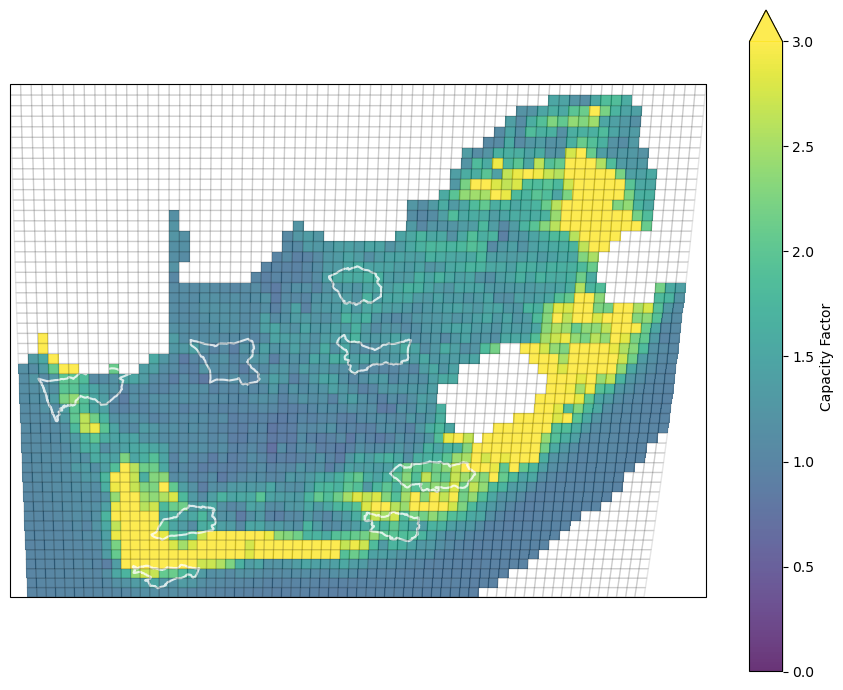

In [ ]:
cf_ratio=0*capacity_factor.copy()
cf_ratio.data=mean_xr.data/capacity_factor.data
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cf_ratio.name = 'Capacity Factor'
cf_ratio.plot(ax=ax, transform=plate(), alpha=0.8, vmin = 0, vmax = 3)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [ ]:
wd =cutout.data.wnd100m.values
names = ['time', 'x', 'y']
index = pd.MultiIndex.from_product([range(s)for s in wd.shape], names=names)
df = pd.DataFrame({'wd': wd.flatten()}, index=index)['wd']
df = df.unstack(level='time').swaplevel().sort_index()

In [ ]:
wind_speed.loc[(16.5,-34.75),'wnd100m'].mean()

/tmp/ipykernel_219763/1879259767.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_speed.loc[(16.5,-34.75),'wnd100m'].mean()


9.296236

/tmp/ipykernel_219763/1548989803.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_speed.loc[(16.5,-34.75),:]


,lon,lat,wnd100m
time,,,
2012-01-01 00:00:00,16.5,-34.75,7.997329
2012-01-01 01:00:00,16.5,-34.75,8.445540
2012-01-01 02:00:00,16.5,-34.75,8.856982
2012-01-01 03:00:00,16.5,-34.75,8.663272
2012-01-01 04:00:00,16.5,-34.75,8.314569
...,...,...,...
2013-01-01 19:00:00,16.5,-34.75,13.877629
2013-01-01 20:00:00,16.5,-34.75,13.459603
2013-01-01 21:00:00,16.5,-34.75,12.718858


In [ ]:
capacity_factor.data[:,2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
cm_xr2.data[25,25]

0.0

In [ ]:
with rasterio.open('../data/bundle/ZAF_capacity-factor_IEC32.tif') as src, rasterio.open('../data/bundle/ZAF_capacity-factor_IEC32e.tif', 'w', **src.meta) as dst:



    for c in cells: 
        resareas_b = resareas.intersects(region.geometry)
        if not resareas_b.any():
            dst.write_band(1, dst_data, window=window)
            stats.append({'mean': 0.})
            continue

        min_max=cells.geometry.bounds
        window = rasterio.windows.from_bounds(min_max['minx'], min_max['miny'], min_max['maxx'], min_max['maxy'], src.transform)

        window = rasterio.windows.from_bounds(min_max['minx'], min_max['miny'], min_max['minxx'], min_max['minxy'], src.transform)
        box = shapely.geometry.box(minx, miny, maxx, maxy)
        transform = rasterio.windows.transform(window, src.transform)

        src_data = src.read(1, window=window)
        dst_data = np.zeros_like(src_data)

        for grid_codes, value in landusetype_percent:
            dst_data.ravel()[np.in1d(src_data.ravel(), grid_codes)] = value

        mask = rasterio.mask.geometry_mask(resareas.loc[resareas_b, 'geometry'], dst_data.shape, transform)
        dst_data = np.ma.array(dst_data, mask=mask, fill_value=0).filled()

        dst.write_band(1, dst_data, window=window)

        stats.extend(rasterstats.zonal_stats(region.geometry, dst_data, affine=transform,
                                             nodata=-999, stats='mean'))

    stats = pd.DataFrame(stats)

    stats['area_ratio'] = stats.pop('mean') / 100
    stats['area'] = regions.to_crs(area_crs).area/1e6 # albert equal area has area in m^2
    stats['available_area'] = stats['area_ratio'] * stats['area']

    if RSA_flag==True:
        area_data = stats.sum()
        area_output = pd.DataFrame(stats.sum(),columns=['RSA']).T
        area_output.loc['area_ratio'] = area_output['available_area']/area_output['area']
        area_output.to_csv(snakemake.output.area)
    else:
        stats.set_index(regions.name).to_csv(snakemake.output.area)

AttributeError: 'GeoAxesSubplot' object has no attribute 'outline_patch'

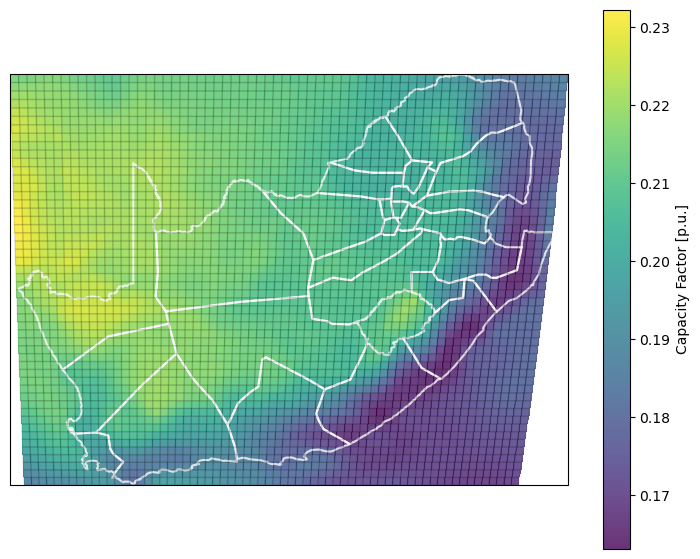

In [ ]:
cap_factors = cutout.pv(panel='CSi', orientation='latitude_optimal', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [ ]:
cutout.wind(turbine='x', smooth=False)